<a href="https://colab.research.google.com/github/mesay21/ML_projects/blob/master/cifar_100_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train ResNet for CIFAR-100 Classification problem

In [0]:
#Mount goole drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#import libraries
import os
import sys
import glob
import pickle
import tensorflow as tf
import numpy as np
from tensorflow.python.client import device_lib
from matplotlib import pyplot as plt

In [0]:
#check system infromation
print('Memory information')
!cat /proc/meminfo | egrep "MemTotal*"
print('\n\nAvailable Devices:\n'+str(device_lib.list_local_devices()))

In [0]:
#read train and test sets using pickle
root_path = '/content/drive/My Drive/google_colab/'
with open(root_path+'Datasets/cifar-100-python/train', 'rb') as fp:
  train = pickle.load(fp, encoding='bytes')
with open(root_path+'Datasets/cifar-100-python/test', 'rb') as fp:
  test = pickle.load(fp, encoding='bytes')

(64, 3072)
(256, 256, 3)


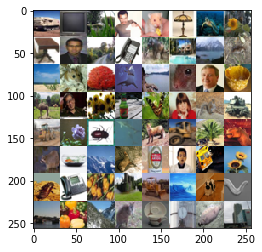

In [5]:
sample_index = np.random.randint(0, len(train[b'data']), size=(64,))
x_sample = train[b'data'][sample_index, :]
print(x_sample.shape)
x_sample = np.transpose(x_sample.reshape(-1, 3, 32, 32), (0, 2, 3, 1))
x_sample = x_sample.reshape((-1, 32, 3))
x_sample = np.concatenate(np.vsplit(x_sample, 8), axis=1)
print(x_sample.shape)
plt.imshow(x_sample)
plt.show()

In [0]:
def normalize(x_train, x_test):
  mu = np.mean(x_train, axis=0)
  std = np.std(x_train, axis=0)
  x_train = (x_train - mu)/std
  x_test = (x_test - mu)/std
  return x_train, x_test

In [0]:
def get_weight(shape):
  w = tf.get_variable('weight', shape=shape,
                      initializer=tf.truncated_normal_initializer(stddev=0.02),
                      trainable=True, dtype=tf.float32)
  return w

def get_bias(shape):
  b = tf.get_variable('bias', shape=shape, initializer=tf.zeros_initializer(),
                      trainable=True, dtype=tf.float32)
  return b

def conv2d(x, out_channel, filter_size, stride=1, name='conv2d'):
  with tf.variable_scope(name):
    input_shape = x.get_shape().as_list()
    w_shape = (filter_size, filter_size, input_shape[-1], out_channel)
    w = get_weight(w_shape)
    b = get_bias((out_channel,))
    conv = tf.nn.conv2d(
        x,
        filter=w,
        strides=stride,
        padding='SAME',
    )
    out = tf.nn.bias_add(conv, b)
    return out

def fc_layer(x, units, name='fc_layer'):
  with tf.variable_scope(name):
    input_shape = x.get_shape().as_list()
    w = get_weight((input_shape[-1], units))
    b = get_bias((units,))
    out = tf.nn.bias_add(tf.matmul(x, w), b)
    return out

def batch_norm(x, state, name='bn'):
  with tf.variable_scope(name):
    input_shape = x.get_shape().as_list()
    beta = tf.get_variable('beta', shape=(input_shape[-1],),
                          initializer=tf.constant_initializer(0.0),
                          trainable=True, dtype=tf.float32)
    gamma = tf.get_variable('gamma', shape=(input_shape[-1],),
                      initializer=tf.constant_initializer(1.0),
                      trainable=True, dtype=tf.float32)
    batch_mu, batch_var = tf.nn.moments(x, (0, 1, 2), keep_dims=True)
    exp_mvng_avrg = tf.train.ExponentialMovingAverage(decay=0.99)
    
    def update_stat():
      apply_mvn_avrg = exp_mvng_avrg.apply([batch_mu, batch_var])
      with tf.control_dependencies([apply_mvn_avrg]):
        return tf.identity(batch_mu), tf.identity(batch_var)
    mean, var = tf.cond(state, update_stat,
                        lambda: (exp_mvng_avrg.average(batch_mu),
                                 exp_mvng_avrg.average(batch_var)))
                                
    x_norm = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return x_norm
  

In [0]:
class CIFARResNet:
  def __init__(self):
    tf.reset_default_graph()
    self.x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3),
                            name='input_data')
    self.y = tf.placeholder(tf.int64, shape=(None,), name='label_index')
    self.is_train = tf.placeholder(tf.bool, shape=(), name='network_state')
    self.num_filters = 64
    self.filter_size = 3
    self.num_classes = 100
    self.batch_size = 64
    self.num_epochs = 10000
    self.lr_rate = 1e-3

  
  def resnet_block(self, x, num_filters, filter_size, mode, name='resnet'):
    with tf.variable_scope(name):
      input_shape = x.get_shape().as_list()
      bn_one = batch_norm(x, state=mode, name='bn_one')
      act_one = tf.nn.leaky_relu(bn_one)
      conv_one = conv2d(act_one, num_filters, filter_size, name='conv_one')
      bn_two = batch_norm(conv_one, state=mode, name='bn_two')
      act_two = tf.nn.leaky_relu(bn_two)
      conv_two = conv2d(act_two, num_filters, filter_size, name='conv_two')
      if input_shape[-1] != num_filters:
        conv_shortcut = conv2d(x, num_filters, filter_size=1,
                               name='conv_shortcut')
        out = tf.add(conv_two, conv_shortcut)
      else:
        out = tf.add(conv_two, x)
      return out
  #create resnet network
  def network(self):
    conv_one = conv2d(self.x, self.num_filters,
                      self.filter_size, name='conv_input')
                                      
    resnet_one = self.resnet_block(conv_one, self.num_filters,
                                   self.filter_size, self.is_train,
                                   name='resnet_one')
    max_pool_one = tf.nn.max_pool2d(resnet_one, 2, 2, padding='SAME')
    resnet_two = self.resnet_block(max_pool_one, 2*self.num_filters,
                                   self.filter_size, self.is_train,
                                   name='resnet_two')
    max_pool_two = tf.nn.max_pool2d(resnet_two, 2, 2, padding='SAME')
    resnet_three = self.resnet_block(max_pool_two, 4*self.num_filters,
                                     self.filter_size, self.is_train,
                                     name='resnet_three')
    max_pool_three = tf.nn.max_pool2d(resnet_three, 2, 2, padding='SAME')
    resnet_four = self.resnet_block(max_pool_three, 8*self.num_filters,
                                    self.filter_size, self.is_train,
                                    name='resnet_four')
    bn_one = batch_norm(resnet_four, state=self.is_train, name='bn_one')
    act_one = tf.nn.leaky_relu(bn_one)
    print('resnet block output: ', act_one.shape)
    ave_pool = tf.nn.avg_pool2d(act_one, 4, 4, padding='SAME')
    
    ave_pool_size = ave_pool.get_shape().as_list()
    ave_pool = tf.reshape(ave_pool, (-1, tf.reduce_prod(ave_pool_size[1:])))
    logits = fc_layer(ave_pool, self.num_classes, name='logits')
    print('logits shape: ', logits.shape)
    return logits
  
  def data_iterator(self, x, y):
    train = tf.data.Dataset.from_tensor_slices((self.x, self.y))
    train = train.repeat().batch(self.batch_size)
    
    iterator = train.make_initializable_iterator()
    next_ = iterator.get_next()
    return iterator, next_
  
  def train(self, x_train, y_train, x_test, y_test):
    gpu_config = tf.ConfigProto()
    gpu_config.gpu_options.allow_growth = True
    y_onehot = tf.placeholder(tf.float32, shape=(None, self.num_classes),
                              name='one_hot_label')
    one_hot = tf.one_hot(self.y, self.num_classes, dtype=tf.float32,
                         name='one_hot_encoder')
    iterator, next_batch = self.data_iterator(x_train, y_train)
    logits = self.network()
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                                     labels=y_onehot))
                                                   
    ###check training parameters#####
    optim = tf.train.AdamOptimizer(self.lr_rate).minimize(loss)
    
    with tf.name_scope('performance'):
      _, accuracy = tf.metrics.accuracy(self.y,
                                        tf.argmax(tf.nn.softmax(logits, axis=-1),
                                                  axis=-1))
                                        
    init_op = tf.group([tf.global_variables_initializer(),
                        tf.local_variables_initializer()])
    tf.get_default_graph().finalize()
    
    with tf.Session(config=gpu_config) as sess:
      sess.run(init_op)
      sess.run(iterator.initializer, feed_dict={self.x:x_train, self.y:y_train})
      num_iter = len(x_train)//self.batch_size
      for i in range(self.num_epochs):
        for _ in range(num_iter):
          x, y = sess.run(next_batch)
          y = one_hot.eval(feed_dict={self.y:y})
          sess.run(optim, feed_dict={self.x:x, y_onehot:y, self.is_train:True})
        if i%10==0:
          x, y = sess.run(next_batch)
          y_ = one_hot.eval(feed_dict={self.y:y})
          train_loss, train_acc = sess.run([loss, accuracy],
                                           feed_dict={self.x:x, y_onehot:y_,
                                                      self.is_train:False,
                                                      self.y:y})                                          
          print('Iteration: %d, Training loss: \
                %.2f Training accuracy: %.2f'%(i, train_loss, train_acc))
        if i%100==0:
          test_loss, test_acc = 0.0, 0.0
          for j in range(0, len(x_test), self.batch_size):
            x = x_test[j:(j+self.batch_size)]
            y = one_hot.eval(feed_dict={self.y:y_test[j:(j+self.batch_size)]})
            temp_loss, temp_acc = sess.run([loss, accuracy],
                                           feed_dict={self.x:x, y_onehot:y,
                                                      self.is_train:False,
                                                      self.y:y_test[j:(j+self.batch_size)]})
            test_loss += (temp_loss*len(x))
            test_acc += (temp_acc*len(x))
          test_loss /= len(x_test)
          test_acc /= len(x_test)                                                              
          print('Iteration: %d, Average test loss: \
                %.2f Average test accuracy: %.2f'%(i, test_loss, test_acc))
      test_loss, test_acc = 0.0, 0.0

      for j in range(0, len(x_test), self.batch_size):
        x = x_test[j:(j+self.batch_size)]
        y = one_hot.eval(feed_dict={self.y:y_test[j:(j+self.batch_size)]})
        temp_loss, temp_acc = sess.run([loss, accuracy],
                                         feed_dict={self.x:x, y_onehot:y,
                                                    self.is_train:False,
                                                    self.y:y_test[j:(j+self.batch_size)]})
        test_loss += (temp_loss*len(x))        
        test_acc += (temp_acc*len(x))
      test_loss /= len(x_test)
      test_acc /= len(x_test)
      print('Final loss and accuracy: %.2f Test accuracy: %.2f'%(test_loss,
                                                                 test_acc)) 
                                                             

In [0]:
x_train = np.transpose(train[b'data'].reshape(-1, 3, 32, 32), (0, 2, 3, 1))
x_test = np.transpose(test[b'data'].reshape(-1, 3, 32, 32), (0, 2, 3, 1))
y_train = np.array(train[b'fine_labels'])
y_test = np.array(test[b'fine_labels'])
x_train, x_test = normalize(x_train, x_test)
resnet = CIFARResNet()
resnet.train(x_train, y_train, x_test, y_test)

W0823 06:38:23.667718 140538142947200 deprecation.py:323] From <ipython-input-8-66ee305ec9d0>:67: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


resnet block output:  (?, 4, 4, 512)
logits shape:  (?, 100)
Iteration: 0, Training loss:                 3.18 Training accuracy: 0.20
Iteration: 0, Average test loss:                 3.29 Average test accuracy: 0.20
Iteration: 10, Training loss:                 0.39 Training accuracy: 0.21
Iteration: 20, Training loss:                 0.33 Training accuracy: 0.21
Iteration: 30, Training loss:                 0.02 Training accuracy: 0.22
Iteration: 40, Training loss:                 0.09 Training accuracy: 0.22
Iteration: 50, Training loss:                 0.08 Training accuracy: 0.23
Iteration: 60, Training loss:                 0.04 Training accuracy: 0.23
Iteration: 70, Training loss:                 0.15 Training accuracy: 0.24
Iteration: 80, Training loss:                 0.08 Training accuracy: 0.24
Iteration: 90, Training loss:                 0.02 Training accuracy: 0.24
Iteration: 100, Training loss:                 0.17 Training accuracy: 0.25
Iteration: 100, Average test los

In [0]:
class CIFARResNet:
  def __init__(self):
    tf.reset_default_graph()
    self.x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3),
                            name='input_data')
    self.y = tf.placeholder(tf.int64, shape=(None,), name='label_index')
    self.is_train = tf.placeholder(tf.bool, shape=(), name='network_state')
    self.num_filters = 64
    self.filter_size = 3
    self.num_classes = 100
    self.batch_size = 64
    self.num_epochs = 10000
    self.lr_rate = 1e-3
  
  def resnet_block(self, x, num_filters, filter_size, mode, name='resnet'):
    with tf.variable_scope(name):
      input_shape = x.get_shape().as_list()
      bn_one = tf.keras.layers.BatchNormalization()(x, training=mode)
      act_one = tf.nn.leaky_relu(bn_one)
      conv_one = conv2d(act_one, num_filters, filter_size, name='conv_one')
      bn_two = tf.keras.layers.BatchNormalization()(conv_one, training=mode)
      act_two = tf.nn.leaky_relu(bn_two)
      conv_two = conv2d(act_two, num_filters, filter_size, name='conv_two')
      if input_shape[-1] != num_filters:
        conv_shortcut = conv2d(x, num_filters, filter_size=1,
                               name='conv_shortcut')
        out = tf.add(conv_two, conv_shortcut)
      else:
        out = tf.add(conv_two, x)
      return out
  #create resnet network
  def network(self):
    conv_one = conv2d(self.x, self.num_filters, self.filter_size, name='conv_input')
                                      
    resnet_one = self.resnet_block(conv_one, self.num_filters,
                                   self.filter_size, self.is_train,
                                   name='resnet_one')
    max_pool_one = tf.nn.max_pool2d(resnet_one, 2, 2, padding='SAME')
    resnet_two = self.resnet_block(max_pool_one, 2*self.num_filters,
                                   self.filter_size, self.is_train,
                                   name='resnet_two')
    max_pool_two = tf.nn.max_pool2d(resnet_two, 2, 2, padding='SAME')
    resnet_three = self.resnet_block(max_pool_two, 4*self.num_filters,
                                     self.filter_size, self.is_train,
                                     name='resnet_three')
    max_pool_three = tf.nn.max_pool2d(resnet_three, 2, 2, padding='SAME')
    resnet_four = self.resnet_block(max_pool_three, 8*self.num_filters,
                                    self.filter_size, self.is_train,
                                    name='resnet_four')
    bn_one = tf.keras.layers.BatchNormalization()(resnet_four,
                                                  training=self.is_train)
    act_one = tf.nn.leaky_relu(bn_one)
    print('resnet block output: ', act_one.shape)
    ave_pool = tf.nn.avg_pool2d(act_one, 4, 4, padding='SAME')
    
    ave_pool_size = ave_pool.get_shape().as_list()
    ave_pool = tf.reshape(ave_pool, (-1, tf.reduce_prod(ave_pool_size[1:])))
    logits = fc_layer(ave_pool, self.num_classes, name='logits')
    print('logits shape: ', logits.shape)
    return logits
  def data_iterator(self):
    train = tf.data.Dataset.from_tensor_slices((self.x, self.y))
    train = train.repeat().batch(self.batch_size)
    
    iterator = train.make_initializable_iterator()
    next_ = iterator.get_next()
    return iterator, next_
  
  def train(self, x_train, y_train, x_test, y_test):
    gpu_config = tf.ConfigProto()
    gpu_config.gpu_options.allow_growth = True
    y_onehot = tf.placeholder(tf.float32, shape=(None, self.num_classes),
                              name='one_hot_label')
    one_hot = tf.one_hot(self.y, self.num_classes, dtype=tf.float32,
                         name='one_hot_encoder')
    iterator, next_ = self.data_iterator()
    logits = self.network()
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                                     labels=y_onehot))
                                                   
    ###check training parameters#####
    optim = tf.train.AdamOptimizer(self.lr_rate).minimize(loss)
    
    with tf.name_scope('performance'):
      _, accuracy = tf.metrics.accuracy(self.y,
                                        tf.argmax(tf.nn.softmax(logits, axis=-1),
                                                  axis=-1))
                                        
    init_op = tf.group([tf.global_variables_initializer(),
                        tf.local_variables_initializer()])
    tf.get_default_graph().finalize()
    
    with tf.Session(config=gpu_config) as sess:
      sess.run(init_op)
      sess.run(iterator.initializer, feed_dict={self.x:x_train, self.y:y_train})
      num_iter = len(x_train)//self.batch_size
      for i in range(self.num_epochs):
        for _ in range(num_iter):
          x, y = sess.run(next_)
          y = one_hot.eval(feed_dict={self.y:y})
          sess.run(optim, feed_dict={self.x:x, y_onehot:y, self.is_train:True})
        if i%10==0:
          x, y = sess.run(next_)
          y_ = one_hot.eval(feed_dict={self.y:y})
          train_loss, train_acc = sess.run([loss, accuracy],
                                           feed_dict={self.x:x, y_onehot:y_,
                                                      self.is_train:False,
                                                      self.y:y})                                          
          print('Iteration: %d, Training loss: \
                %.2f Training accuracy: %.2f'%(i, train_loss, train_acc))
        if i%100==0:
          test_loss, test_acc = 0.0, 0.0
          for j in range(0, len(x_test), self.batch_size):
            x = x_test[j:(j+self.batch_size)]
            y = one_hot.eval(feed_dict={self.y:y_test[j:(j+self.batch_size)]})
            temp_loss, temp_acc = sess.run([loss, accuracy],
                                           feed_dict={self.x:x, y_onehot:y,
                                                      self.is_train:False,
                                                      self.y:y_test[j:(j+self.batch_size)]})
            test_loss += (temp_loss*len(x))
            test_acc += (temp_acc*len(x))
          test_loss /= len(x_test)
          test_acc /= len(x_test)                                                              
          print('Iteration: %d, Average test loss: \
                %.2f Average test accuracy: %.2f'%(i, test_loss, test_acc))
      test_loss, test_acc = 0.0, 0.0

      for j in range(0, len(x_test), self.batch_size):
        x = x_test[j:(j+self.batch_size)]
        y = one_hot.eval(feed_dict={self.y:y_test[j:(j+self.batch_size)]})
        temp_loss, temp_acc = sess.run([loss, accuracy],
                                         feed_dict={self.x:x, y_onehot:y,
                                                    self.is_train:False,
                                                    self.y:y_test[j:(j+self.batch_size)]})
        test_loss += (temp_loss*len(x))        
        test_acc += (temp_acc*len(x))
      test_loss /= len(x_test)
      test_acc /= len(x_test)
      print('Final loss and accuracy: %.2f Test accuracy: %.2f'%(test_loss,
                                                                 test_acc)) 